In [18]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_dictionary
from io_functions import load_data
import os
import json
import glob
import inspect


### Generate population-tree features for each given tree span and gamma parameter

In [5]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))
fcm, scm = connectome_average(fc_group, sc_group)

In [37]:
g = 0.5
W = matrix_fusion(g, fcm, scm)
tree_min = 10
tree_max = 20
t_dict = tree_dictionary(tree_min, tree_max, W)
json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".json"), "w"))
full_features = []
for sc, fc in zip(sc_group, fc_group):
    t_features, t_features_names = tree_connectivity(tree_min, tree_max, W, sc, fc)
    full_features.append(t_features)

full_df = pd.DataFrame(full_features)
full_df.columns = t_features_names
full_df = full_df.loc[:, ~full_df.apply(lambda x: x.duplicated(), axis=1).all()].copy()
#full_df.to_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"), index=False)


### Store a nifti of a given module

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import json

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.5.json"), "r").read())
rois = t_dictionary['lvl_20_mod_3']

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
atlas_data = atlas.get_fdata()
atlas_rois = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
atlas_rois_image = nib.Nifti1Image(atlas_rois, affine=atlas.affine)
nib.save(atlas_rois_image, os.path.join(project_path, "craddock_2128_2mm_lvl_20_mod_3.nii.gz"))


### Neuropsychological score prediction using population-tree features

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict

#### Only training (cross-validation) using five different linear models

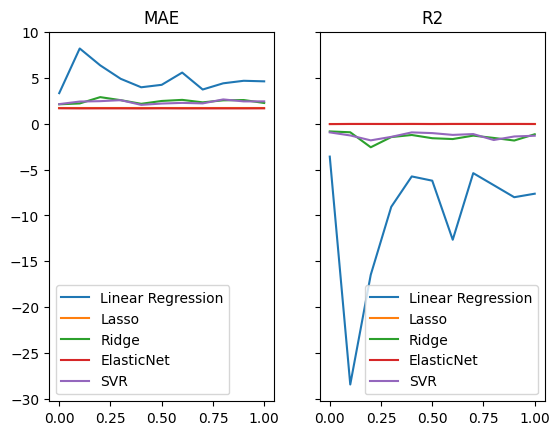

In [40]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = ElasticNet() 
clf_5 = SVR(kernel='linear') 

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','ElasticNet', 'SVR']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, sharex=True)
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    r2_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
        X = scaler.fit_transform(df)
        Y_pred = cross_val_predict(clf, X, y, cv=5)
        mae = mean_absolute_error(y, Y_pred)
        r2 = r2_score(y, Y_pred)
        mae_plot.append(mae)
        r2_plot.append(r2)

    axs[0].plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    axs[0].set_title("MAE")
    axs[1].plot(np.arange(0, 1.1, 0.1), r2_plot, label=clas_names[idx])
    axs[1].set_title("R2")
axs[0].legend()
axs[1].legend()

In [41]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
#model = SVR(kernel='linear') 
model = Ridge()
g = 0.4
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(g) + ".csv"))
X = scaler.fit_transform(df)

selector = RFECV(model, step=1, cv=10, scoring='neg_mean_absolute_error')
selector.fit(X, y)



RFECV(cv=10, estimator=Ridge(), scoring='neg_mean_absolute_error')

In [42]:
X_sorted = X[:, selector.ranking_]
mae = []
for idx in range(1,len(selector.ranking_)):
    X_sub_samp = X_sorted[:, :idx]
    Y_pred = cross_val_predict(model, X_sub_samp, y, cv=10)
    mae.append(mean_absolute_error(y, Y_pred))


Text(0.5, 1.0, 'Ridge')

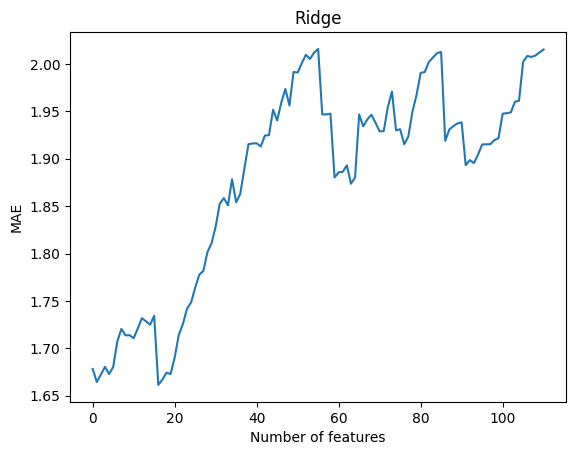

In [43]:
plt.plot(mae)
plt.xlabel("Number of features")
plt.ylabel("MAE")
plt.title("Ridge")

In [227]:
Xt = X[:, :1]
Xt.shape


(136, 1)